# **Homework 5: Semantic Segmentation**



Objectives:
* Get familiar with semantic segmentation.
* Understand the basic pipeline.
* Solve some problems of semantic segmentation.

Total points: 100

If any questions, please contact the TAs via TA hours, or email.


# **Download and install**

In [3]:
# Download data
!gdown 1g10Er1vhNbrqa0pZf0R08B9RrmRxIoWt

# Install filterpy
! unzip LabPicsV1.zip

from IPython.display import clear_output
clear_output()

In [9]:
# System
import os, sys, time, datetime, random
from tqdm import tqdm

# Data processing
import numpy as np

# Pytorch
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as tf
import torchvision.models.segmentation
from torch.autograd import Variable

# Image processing
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from skimage import io


# **Semantic segmentation with pre-trained DeepLabv3**

## **About the LabPicsV1 Dataset**

The Vector-LabPics V1 dataset contains 2187 images of chemical experiments with materials within mostly transparent vessels in various laboratory settings and in everyday conditions such as beverage handling.

Each image in the dataset has an annotation of the region of each material phase and its type.

In addition, the region of each vessel and its labels, parts, and corks are also marked.

## **About the DeepLabv3**

DeepLabv3 is a semantic segmentation architecture. To handle the problem of segmenting objects at multiple scales, modules are designed which employ atrous convolution in cascade or in parallel to capture multi-scale context by adopting multiple atrous rates.

Furthermore, the Atrous Spatial Pyramid Pooling (ASSP) module from DeepLabv2 augmented with image-level features encoding global context and further boost performance. The changes to the ASSP module are that the authors apply global average pooling on the last feature map of the model, feed the resulting image-level features to a 1 × 1 convolution with 256 filters (and batch normalization), and then bilinearly upsample the feature to the desired spatial dimension.

In the end, the improved ASPP consists of one 1×1 convolution and three 3 × 3 convolutions with rates = (6, 12, 18) when output stride = 16 (all with 256 filters and batch normalization), and the image-level features.

## Utils

In [12]:
width=height=900 # image width and height
batchSize=2

TrainFolder="C:/Users/Ryan Barry/OneDrive - rit.edu/Laptop Backup/Desktop/RIT/Robot Perception/Homework/HW5/content/LabPicsV1/Simple/Train/"
ListImages=os.listdir(os.path.join(TrainFolder, "Image")) # Create list of images

transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((height,width),tf.InterpolationMode.NEAREST),tf.ToTensor()])

For convienence, we only train the semantic segmentation with class of vessel and filled. You may extend this task to all categories.

## Read random image (30pts)

In [3]:
def ReadRandomImage(): # First lets load random image and  the corresponding annotation
    #(30pts)TODO: Fill this function
    # 1. Select a RANDOM image from /content/LabPicsV1/Simple/Train/Image/ folder (5pts)
    #    NOTE: be careful with channel numbers of the image, we need RGB channels only

    # 2. Pick the 1_Vessel and 16_Filled semantic masks for this image (5pts)
    #    NOTE: /content/LabPicsV1/Simple/Train/Semantic/ folder contains different semantic classes

    # 3. Create annotation map AnnMap with the same size as the image,
    #    where we set 1 for vessel pixels and 2 for filled pixels, and 0 for the others (15pts)

    # 4. Apply transformImg to the image and transformAnn to AnnMap (5pts)
    random_idx=np.random.randint(0,len(ListImages)) # Select random image
    Img=cv2.imread(os.path.join(TrainFolder, "Image", ListImages[random_idx]))[:,:,0:3]
    Filled =  cv2.imread(os.path.join(TrainFolder, "Semantic/16_Filled", ListImages[random_idx].replace("jpg","png")),0)
    Vessel =  cv2.imread(os.path.join(TrainFolder, "Semantic/1_Vessel", ListImages[random_idx].replace("jpg","png")),0)
    AnnMap = np.zeros(Img.shape[0:2],np.float32)
    if Vessel is not None:  AnnMap[ Vessel == 1 ] = 1
    if Filled is not None:  AnnMap[ Filled  == 1 ] = 2
    Img=transformImg(Img)
    AnnMap=transformAnn(AnnMap)

    return Img,AnnMap

## Load batch of images (10pts)

In [4]:
def LoadBatch():
    #(10pts)TODO: Load batch of images, use random image for each batch
    img_batch = torch.zeros([batchSize,3,height,width])
    ann = torch.zeros([batchSize, height, width])
    for i in range(batchSize):
        img_batch[i],ann[i]=ReadRandomImage()

    return img_batch, ann

## Load and set net and optimizer

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True) # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 3 classes
Net=Net.to(device)
Learning_Rate=1e-5
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate)

c:\Users\Ryan Barry\OneDrive - rit.edu\Laptop Backup\Desktop\RIT\Robot Perception\Homework\HW5\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ryan Barry\OneDrive - rit.edu\Laptop Backup\Desktop\RIT\Robot Perception\Homework\HW5\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train (40pts)

In [10]:
for itr in tqdm(range(2000), position=0, leave=True): # Training loop
    #(40pts)TODO: Train the model
    # hint:
    #      1. Set crossentropy loss as loss function
    #      2. Calculate loss with ann.long
    img_batch,ann=LoadBatch()
    img_batch=torch.autograd.Variable(img_batch,requires_grad=False).to(device)
    ann = torch.autograd.Variable(ann, requires_grad=False).to(device)
    Pred=Net(img_batch)['out']
    Net.zero_grad()
    criterion = torch.nn.CrossEntropyLoss()
    Loss=criterion(Pred,ann.long()) # Calculate cross entropy loss
    Loss.backward() # Backpropogate loss
    optimizer.step() # Apply gradient descent change to weight
    seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get  prediction 
    


#Save model weight at the end
print("Saving Model Final.torch")
torch.save(Net.state_dict(),   "Final.torch")

100%|██████████| 2000/2000 [10:02<00:00,  3.32it/s]

Saving Model Final.torch


## Inference

### Origin image (10pts)

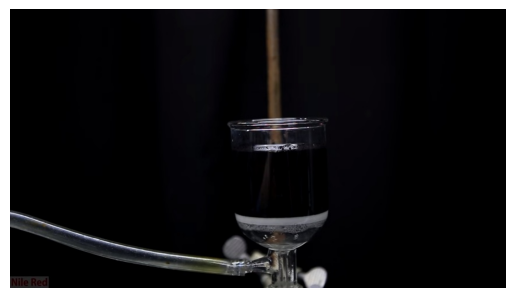

In [30]:
modelPath = "Final.torch"  # Path to trained model
#(10pts)TODO: Display the original image
# Select an image (any image that contains vessel and liquid), display the original image
directory = "C:/Users/Ryan Barry/OneDrive - rit.edu/Laptop Backup/Desktop/RIT/Robot Perception/Homework/HW5/content/LabPicsV1/Simple/Test/Image"
# Img = cv2.imread(f"{directory}/Koen2All_Chemistry experiment 2. - Coloured flask.-screenshot (1).jpg")
Img = cv2.imread(f"{directory}/NileRed_Getting Manganese Dioxide, Zinc and Carbon from Batteries-screenshot (3).jpg")
height_orgin, widh_orgin, d = Img.shape

plt.imshow(Img[:,:,::-1])
plt.axis('off')
plt.show()

### Semantic segmentation visualization (10pts)

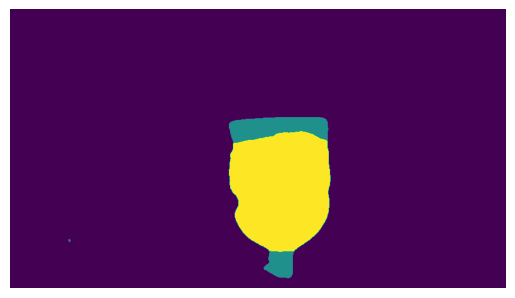

In [31]:
Img = transformImg(Img)  # Transform to pytorch
Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)

#(10pts)TODO: Output Visualization
# Run the net on the image selected above, and display the segmentation output
# hint: don't forget to set to evaluation mode, don't forget to resize

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True) # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 3 classes

Net.load_state_dict(torch.load(modelPath))
Net=Net.to(device)
Net.eval()
Prd = Net(Img)['out']  # Run net# resize to orginal size
Prd = tf.Resize((height_orgin,widh_orgin))(Prd[0])#Convert probability to class map
seg = torch.argmax(Prd, 0).cpu().detach().numpy()  
plt.imshow(seg)  # display image
plt.axis('off')
plt.show()
